## Step 1. 데이터셋 내려받기

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

데이터셋을 로드하고 분할합니다.\
데이터셋은 8:1:1의 비율로 train, validation, test 데이터를 분할합니다.

In [2]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    name='tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    data_dir='~/aiffel/exploration/tf_flowers/',
    with_info=True,
    as_supervised=True,
)

2행 5열로 10개의 이미지를 출력해봅니다.

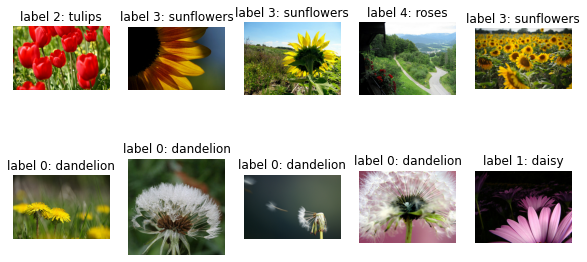

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):  # 10개의 데이터를 가져 옵니다.
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

## Step 2. 데이터셋을 모델에 넣을 수 있는 형태로 준비하기

이미지를 같은 크기로 formatting 하기

In [4]:
IMG_SIZE = 224 # 리사이징할 이미지의 크기

def format_example(image, label):
    image = tf.cast(image, tf.float32)  # image=float(image)같은 타입캐스팅의  텐서플로우 버전입니다.
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = (image/255.0) # 픽셀값의 scale 수정
    return image, label

train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

print(train)
print(validation)
print(test)

<MapDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>


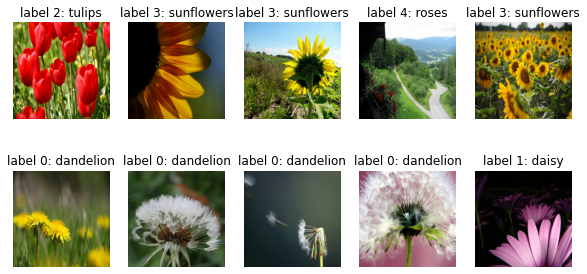

In [5]:
plt.figure(figsize=(10, 5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

train_batches, validation_batches, test_batches 만들기

In [6]:
# 한 스텝에 학습시킬 데이터의 개수인 BATCH_SIZE와 학습 데이터를 적절히 섞어줄 SHUFFLE_BUFFER_SIZE를 설정해주겠습니다.
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

# train_batches, validation_batches, test_batches를 만들어 주겠습니다. 
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

## Step 3. 모델 설계하기

In [7]:
# basemodel을 활용하여 모델 설계
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# VGG16 활용
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

58900480/58889256 [==============================] - 0s 0us/step


In [8]:
base_model.trainable = False

# 모델 정의
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),  # 정규화 레이어 추가
    tf.keras.layers.Dropout(0.5),  # 드롭아웃 레이어 추가
    tf.keras.layers.Dense(256, activation='relu'),  # 추가 레이어
    tf.keras.layers.BatchNormalization(),  # 정규화 레이어 추가
    tf.keras.layers.Dropout(0.5),  # 드롭아웃 레이어 추가
    tf.keras.layers.Dense(128, activation='relu'),  # 추가 레이어
    tf.keras.layers.BatchNormalization(),  # 정규화 레이어 추가
    tf.keras.layers.Dropout(0.5),  # 드롭아웃 레이어 추가
    tf.keras.layers.Dense(5, activation='softmax')  # tf_flowers 데이터셋에서는 class의 갯수가 5가지
])

## Step 4. 모델 학습시키기

In [9]:
# 모델 학습
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',   # 다중분류이기 때문에 sparse_categorical_crossentropy 사용
              metrics=['accuracy'])

history = model.fit(train_batches, 
                    epochs=20, # epochs를 20으로 증가
                    validation_data=validation_batches)

Epoch 1/20
92/92 [==============================] - 68s 240ms/step - loss: 1.5425 - accuracy: 0.5041 - val_loss: 1.1652 - val_accuracy: 0.6812
Epoch 2/20
92/92 [==============================] - 14s 142ms/step - loss: 0.9838 - accuracy: 0.6553 - val_loss: 0.8998 - val_accuracy: 0.6948
Epoch 3/20
92/92 [==============================] - 14s 143ms/step - loss: 0.8240 - accuracy: 0.7084 - val_loss: 0.6990 - val_accuracy: 0.7548
Epoch 4/20
92/92 [==============================] - 14s 145ms/step - loss: 0.7267 - accuracy: 0.7401 - val_loss: 0.6048 - val_accuracy: 0.7602
Epoch 5/20
92/92 [==============================] - 14s 147ms/step - loss: 0.6702 - accuracy: 0.7589 - val_loss: 0.5402 - val_accuracy: 0.7793
Epoch 6/20
92/92 [==============================] - 15s 153ms/step - loss: 0.6172 - accuracy: 0.7752 - val_loss: 0.5793 - val_accuracy: 0.7657
Epoch 7/20
92/92 [==============================] - 15s 156ms/step - loss: 0.5801 - accuracy: 0.7946 - val_loss: 0.4952 - val_accuracy: 0.8065

## Step 5. 모델 성능 평가하기

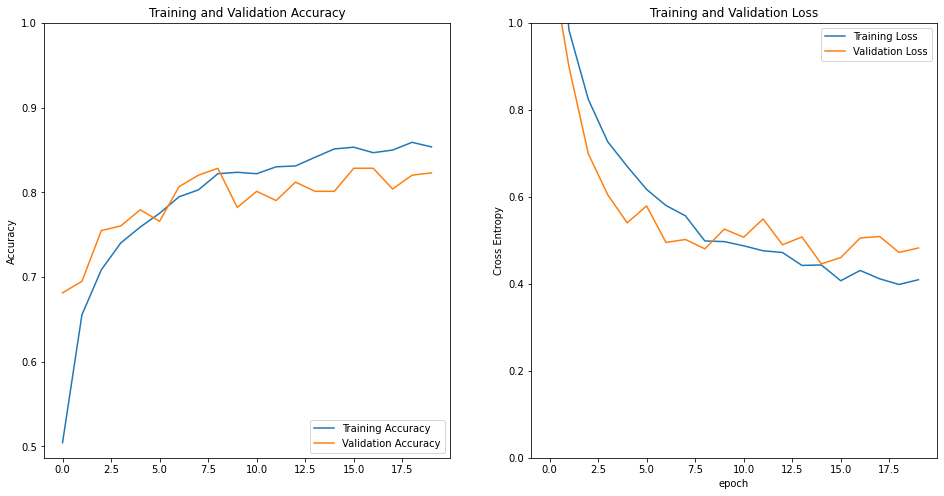

In [10]:
# 그래프 그리기
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [11]:
# 각 이미지의 예측 값
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

array([[1.72356633e-03, 3.45854927e-03, 6.73134983e-01, 1.61071680e-02,
        3.05575669e-01],
       [9.99953628e-01, 2.64116261e-06, 5.21681523e-06, 1.81415857e-07,
        3.84177547e-05],
       [7.63343990e-01, 7.31207579e-02, 2.41397750e-02, 1.09206803e-01,
        3.01886518e-02],
       [7.81146373e-05, 4.25995735e-04, 5.15723646e-01, 1.53321162e-04,
        4.83618915e-01],
       [9.96117234e-01, 9.57064796e-04, 1.08485494e-03, 5.43249298e-05,
        1.78650615e-03],
       [9.98449564e-01, 1.02376791e-04, 1.48451349e-04, 1.96633075e-04,
        1.10299222e-03],
       [4.98975860e-03, 1.82029940e-02, 1.01500452e-01, 6.36119256e-03,
        8.68945599e-01],
       [1.15761667e-01, 7.11089194e-01, 3.83717031e-03, 1.46260202e-01,
        2.30518691e-02],
       [6.98354328e-04, 1.70084080e-04, 2.08953675e-02, 7.45276511e-01,
        2.32959673e-01],
       [9.99884129e-01, 4.26830811e-05, 1.79179424e-05, 1.06490097e-06,
        5.42872149e-05],
       [9.97592092e-01, 1.0367

In [12]:
# 예측 결과
import numpy as np
predictions = np.argmax(predictions, axis=1)
predictions

array([2, 0, 0, 2, 0, 0, 4, 1, 3, 0, 0, 0, 3, 2, 0, 3, 2, 0, 2, 4, 2, 0,
       2, 0, 0, 3, 1, 4, 4, 3, 0, 4])

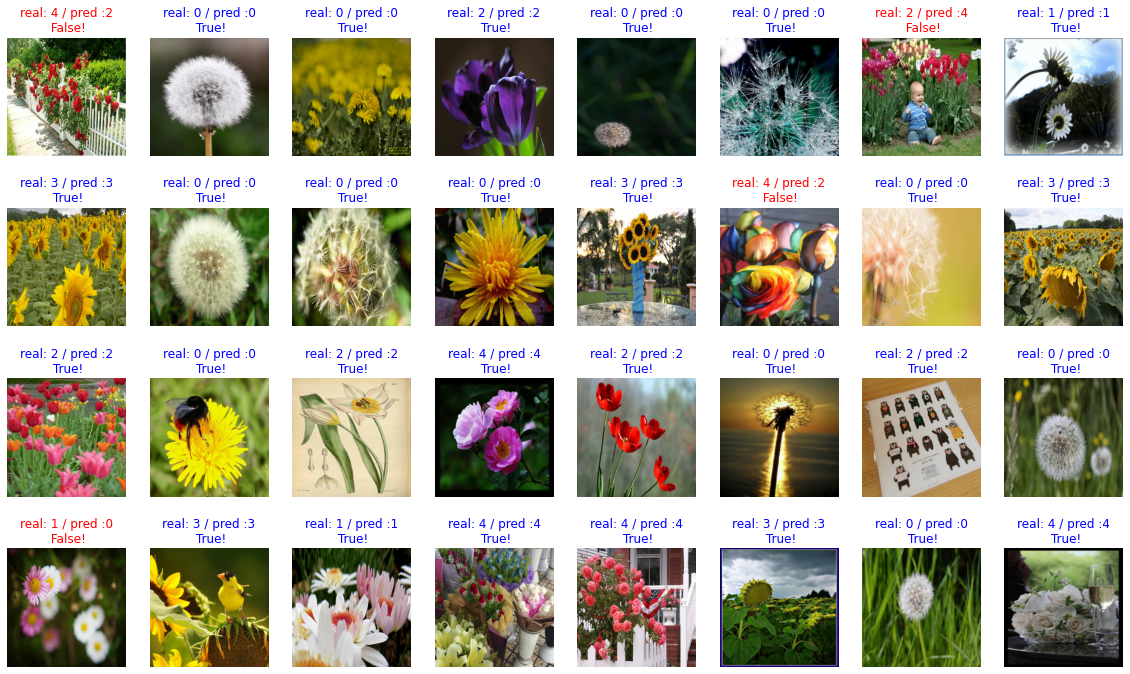

In [15]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

In [16]:
# 위의 32개에 대하여 최종 정확도

count = 0
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct:
        count = count + 1

print(count / 32 * 100)

87.5
